In [338]:
import numpy as np
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import cdist

In [363]:
class BuggyPCA:
    def __init__(self, dims) -> None:
        self.dims = dims

    def fit_transform(self, data):
        self.data = data
        self.temp_data = deepcopy(data)

        self.best_vectors = []
        while self.temp_data.shape[-1] != self.dims:
            covariance_mat = np.cov(self.temp_data, rowvar=False)
            eigen_values, eigen_vecs = np.linalg.eigh(covariance_mat)

            sorted_eigan_values_index = np.argsort(eigen_values)[::-1]
            sorted_eigen_values = eigen_values[sorted_eigan_values_index]
            sorted_eigen_vectors = eigen_vecs[:, sorted_eigan_values_index]
            best_vector = sorted_eigen_vectors[:,0:self.temp_data.shape[1]-1]

            self.best_vectors.append(best_vector)
            transformed_data = np.dot(best_vector.T, self.temp_data.T).T
            self.temp_data = transformed_data

        self.best_vectors.reverse()
        return self.temp_data
    
    def reconstruct(self):
        reconstruction = deepcopy(self.temp_data)
        for vector in self.best_vectors:
            reconstruction = reconstruction @ vector.T 

        err = mean_squared_error(self.data, reconstruction)

        return reconstruction, err
    

In [340]:
class DemeanedPCA:
    def __init__(self, dims) -> None:
        self.dims = dims

    def fit_transform(self, data):
        self.data = data
        self.temp_data = deepcopy(data)
        self.mean = np.mean(self.temp_data, axis = 0)
        self.temp_data = self.temp_data - self.mean

        self.best_vectors = []
        while self.temp_data.shape[-1] != self.dims:
            covariance_mat = np.cov(self.temp_data, rowvar=False)
            eigen_values, eigen_vecs = np.linalg.eigh(covariance_mat)
    
            sorted_eigan_values_index = np.argsort(eigen_values)[::-1]
            sorted_eigen_values = eigen_values[sorted_eigan_values_index]
            sorted_eigen_vectors = eigen_vecs[:, sorted_eigan_values_index]
            best_vector = sorted_eigen_vectors[:,0:self.temp_data.shape[1]-1]

            self.best_vectors.append(best_vector)
            transformed_data = np.dot(best_vector.T, self.temp_data.T).T
            self.temp_data = transformed_data
        
        self.best_vectors.reverse()
        return self.temp_data
    
    def reconstruct(self):
        reconstruction = deepcopy(self.temp_data)
        for vector in self.best_vectors:
            reconstruction = reconstruction @ vector.T

        reconstruction = reconstruction + self.mean 

        err = mean_squared_error(self.data, reconstruction)

        return reconstruction, err

In [341]:
class NormalizedPCA:
    def __init__(self, dims) -> None:
        self.dims = dims

    def fit_transform(self, data):
        self.data = data
        self.temp_data = deepcopy(data)
        self.mean = np.mean(self.temp_data, axis = 0)
        self.std_dev = np.std(self.temp_data, axis=0)
        self.temp_data = (self.temp_data - self.mean)/self.std_dev

        self.best_vectors = []
        while self.temp_data.shape[-1] != self.dims:
            covariance_mat = np.cov(self.temp_data, rowvar=False)
            eigen_values, eigen_vecs = np.linalg.eigh(covariance_mat)

            sorted_eigan_values_index = np.argsort(eigen_values)[::-1]
            sorted_eigen_values = eigen_values[sorted_eigan_values_index]
            sorted_eigen_vectors = eigen_vecs[:, sorted_eigan_values_index]
            best_vector = sorted_eigen_vectors[:,0:self.temp_data.shape[1]-1]

            self.best_vectors.append(best_vector)

            transformed_data = np.dot(best_vector.T, self.temp_data.T).T
            self.temp_data = transformed_data
        
        self.best_vectors.reverse()
        return self.temp_data
    
    def reconstruct(self):
        reconstruction = deepcopy(self.temp_data)
        for vector in self.best_vectors:
            reconstruction = reconstruction @ vector.T
        
        reconstruction = (reconstruction*self.std_dev) + self.mean

        err = mean_squared_error(self.data, reconstruction)

        return reconstruction, err

In [342]:
class DRO:
    def __init__(self, dims) -> None:
        self.dims = dims

    def fit_transform(self, data):
        self.data = data
        self.temp_data = deepcopy(data)
        self.mean = np.mean(self.temp_data, axis = 0)
        self.temp_data = self.temp_data - self.mean
        k = self.dims
        U, S, VT = np.linalg.svd(self.temp_data, full_matrices=False)
        self.U = U
        self.S = S
        self.VT = VT
        # transformed_data = np.dot(U[:, :k], np.dot(np.diag(S[:k]), VT[:k, :]))
        transformed_data = U[:, :k] @ np.diag(S[:k])
        self.temp_data = transformed_data
        return self.temp_data
    
    def reconstruct(self):
        reconstruction = self.U[:, :self.dims] @ np.diag(self.S[:self.dims]) @ self.VT[:self.dims, :]
        reconstruction = reconstruction + self.mean
        
        err = mean_squared_error(self.data, reconstruction)
        return reconstruction, err


In [343]:
dim2_data = np.loadtxt('./data/data2D.csv', delimiter=',')
dim2_data.shape

(50, 2)

In [344]:
dim1000_data = np.loadtxt('./data/data1000D.csv', delimiter=',')
dim1000_data.shape

(500, 1000)

In [364]:
methods = [BuggyPCA, DemeanedPCA, NormalizedPCA, DRO]
method_names = ["BuggyPCA", "DemeanedPCA", "NormalizedPCA", "DRO"]
for index, method in enumerate(methods):
    model = method(1)
    model.fit_transform(dim2_data).shape
    reconstruction, err = model.reconstruct()   
    print(err, method_names[index])
    
    # sns.scatterplot(x=dim2_data[:,0], y=dim2_data[:,1])
    # sns.scatterplot(x=reconstruction[:,0], y=reconstruction[:,1])
    # plt.title(method_names[index])
    # plt.xlabel("X")
    # plt.ylabel("Y")
    # plt.show()

22.682578356094265 BuggyPCA
0.005003042814256461 DemeanedPCA
0.024736041727385333 NormalizedPCA
0.005003042814256459 DRO


In [346]:
methods = [BuggyPCA, DemeanedPCA, NormalizedPCA, DRO]
method_names = ["BuggyPCA", "DemeanedPCA", "NormalizedPCA", "DRO"]
for index, method in enumerate(methods):
    print("Fitting model", method_names[index])
    model = method(29)
    model.fit_transform(dim1000_data)
    reconstruction, err = model.reconstruct()   
    print(err, method_names[index])
    
    # sns.scatterplot(x=dim2_data[:,0], y=dim2_data[:,1])
    # sns.scatterplot(x=reconstruction[:,0], y=reconstruction[:,1])
    # plt.title(method_names[index])
    # plt.xlabel("X")
    # plt.ylabel("Y")
    # plt.show()

Fitting model BuggyPCA


500.3205868312981 BuggyPCA
Fitting model DemeanedPCA
0.8030552376039611 DemeanedPCA
Fitting model NormalizedPCA
0.8073729535644245 NormalizedPCA
Fitting model DRO
0.8030552376039611 DRO


In [347]:
buggy = BuggyPCA(1)
buggy.fit_transform(dim2_data).shape
reconstruction, err = buggy.reconstruct()

# buggy2 = BuggyPCA(988)
# buggy2.fit_transform(dim1000_data).shape
# reconstruction, err = buggy2.reconstruct()[1]

c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: >

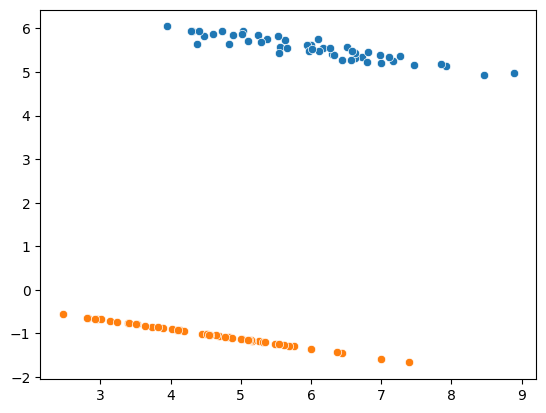

In [348]:
sns.scatterplot(x=dim2_data[:,0], y=dim2_data[:,1])
sns.scatterplot(x=reconstruction[:,0], y=reconstruction[:,1])

In [349]:
demeaned = DemeanedPCA(1)
demeaned.fit_transform(dim2_data).shape
print(demeaned.reconstruct()[1])

0.005003042814256461


In [350]:
normalized = NormalizedPCA(1)
normalized.fit_transform(dim2_data).shape
print(normalized.reconstruct()[1])

0.024736041727385333


In [351]:
dro = DRO(29)
dro.fit_transform(dim1000_data).shape

(500, 29)

In [352]:
dro.reconstruct()[1]

0.8030552376039611

c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(20.0, 40.0)

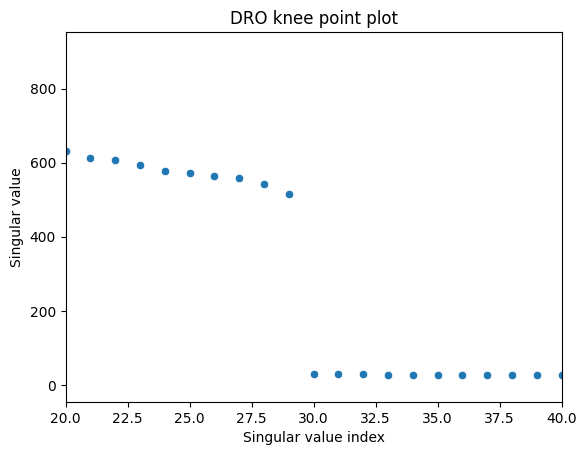

In [353]:
sns.scatterplot(x=range(len(dro.S)), y=dro.S)
plt.title("DRO knee point plot")
plt.xlabel("Singular value index")
plt.ylabel("Singular value")
plt.xlim(20,40)
# plt.xticks(range(20, 41, 1))